## Battle of the Neighborhoods

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
# !conda update -n base -c defaults conda
!conda install -c conda-forge lxml --yes
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge bs4 --yes
# from bs4 import BeautifulSoup

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from IPython.display import HTML
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 1. Downloading and Exploring data for New York City

New York City has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the github

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [3]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Here we Notice that all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
newyork_neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [5]:
newyork_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Now we will tranform the data of nested Python dictionaries into a *pandas* dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_neighborhoods = pd.DataFrame(columns=column_names)

for data in newyork_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_neighborhoods = newyork_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
newyork_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Making sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(newyork_neighborhoods['Borough'].unique()),
        newyork_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In this dataset, there are some neighborhoods having same name but are located in different boroughs, e.g.

In [8]:
newyork_neighborhoods_count = newyork_neighborhoods['Neighborhood'].value_counts()
newyork_neighborhoods_count[newyork_neighborhoods_count > 1]

Bay Terrace    2
Chelsea        2
Murray Hill    2
Sunnyside      2
Name: Neighborhood, dtype: int64

In [9]:
newyork_neighborhoods[newyork_neighborhoods['Neighborhood'] == 'Chelsea']

,Borough,Neighborhood,Latitude,Longitude
116,Manhattan,Chelsea,40.744035,-74.003116
244,Staten Island,Chelsea,40.594726,-74.189560


To solve the problem, we can simply include the borough name along the name of these neighborhoods.

In [10]:
for ind in range(newyork_neighborhoods.shape[0]):
    nyn_ = newyork_neighborhoods.loc[ind, 'Neighborhood']
    if newyork_neighborhoods[newyork_neighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = newyork_neighborhoods[newyork_neighborhoods['Neighborhood'] == nyn_].index.tolist()
        for ind1 in ind_:
            nyb__ = newyork_neighborhoods.loc[ind1, 'Borough']
            newyork_neighborhoods.loc[ind1, 'Neighborhood'] = nyn_ + ', ' + nyb__
            
newyork_neighborhoods[newyork_neighborhoods['Neighborhood'].str.startswith('Chelsea')]

,Borough,Neighborhood,Latitude,Longitude
116,Manhattan,"Chelsea, Manhattan",40.744035,-74.003116
244,Staten Island,"Chelsea, Staten Island",40.594726,-74.189560


### Using geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with neighborhoods superimposed on top.

In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_neighborhoods['Latitude'], newyork_neighborhoods['Longitude'], newyork_neighborhoods['Borough'], newyork_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Using Foursquare API to explore the neighborhoods and retrieving Venue Data For New York City

#### Define Foursquare Credentials and Version

In [13]:
# CLIENT_ID = 'FLH3C5A5XXJGG2JJJS1FNVQCXXVIM4UKJJEPIFATILJUN1FM' # your Foursquare ID
# CLIENT_SECRET = 'V0UFN5WB10JQPBV3EMW2X22RH5FGBBRZ2ORIVPQ1DMFTKAFX' # your Foursquare Secret
# VERSION = '20180605' # Foursquare API version
# LIMIT=100 #Limit the number of nearby venues returned

In [14]:
# Foursquare API credentials
CLIENT_ID = 'A1VPXW0G4VZLCKIMZUOGCWBXBGIY5UP21CRGT0R4OJXJOWBQ' 
CLIENT_SECRET = 'HK051UQF5HLYE5044ZAZ3R00GBQS05DCO25UV24Y531IYBQT' 
VERSION = '20180605'
LIMIT=100

#### Let's create a function to retrieve information about venues in each neighborhood. It takes list of neighborhood names, latitudes, longitudes and radius.     It returns a dataframe with information about each neighborhood and its venues.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now lets run the above function on each neighborhood.

In [16]:
# type your answer here

newyork_venues = getNearbyVenues(names=newyork_neighborhoods['Neighborhood'],
                                   latitudes=newyork_neighborhoods['Latitude'],
                                   longitudes=newyork_neighborhoods['Longitude']
                                  )



Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [17]:
print(newyork_venues.shape)
newyork_venues.head()

(10131, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check how many venues were returned for each neighborhood

In [18]:
newyork_venues.groupby('Neighborhood').size()

Neighborhood
Allerton                       31
Annadale                       11
Arden Heights                   5
Arlington                       6
Arrochar                       22
Arverne                        20
Astoria                       100
Astoria Heights                13
Auburndale                     22
Bath Beach                     46
Battery Park City              66
Bay Ridge                      80
Bay Terrace, Queens            37
Bay Terrace, Staten Island     10
Baychester                     20
Bayside                        74
Bayswater                       1
Bedford Park                   36
Bedford Stuyvesant             28
Beechhurst                     17
Bellaire                       13
Belle Harbor                   17
Bellerose                      19
Belmont                        97
Bensonhurst                    36
Bergen Beach                    7
Blissville                     18
Bloomfield                      4
Boerum Hill                    90
B

#### Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 430 uniques categories.


<a id='item3'></a>

## Lets perform one-hot encoding on the venue category variable

In [20]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood_'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North

And let's examine the new dataframe size.

In [21]:
newyork_onehot.shape

(10131, 431)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
newyork_grouped = newyork_onehot.groupby('Neighborhood_').mean().reset_index()
newyork_grouped.head()

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North

#### The most common categories for each neighborhood

In [23]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [24]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
newyork_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_categories_sorted['Neighborhood_'] = newyork_grouped['Neighborhood_']

for ind in np.arange(newyork_grouped.shape[0]):
    newyork_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        newyork_grouped.iloc[ind, :], num_top_venues)

newyork_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Allerton,Pizza Place,Deli / Bodega,Discount Store,Supermarket,Spa,Chinese Restaurant,Gas Station,Playground,Bakery,Pharmacy
1,Annadale,Pizza Place,American Restaurant,Food,Train Station,Restaurant,Dance Studio,Park,Deli / Bodega,Diner,Farm
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,Farmers Market
3,Arlington,Deli / Bodega,Coffee Shop,Bus Stop,Home Service,Boat or Ferry,Grocery Store,Flea Market,Falafel Restaurant,Farm,Farmers Market
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Beach,Hotel,Middle Eastern Restaurant,Outdoors & Recreation,Pharmacy,Liquor Store,Bagel Shop


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [25]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 0, 0, 0, 3, 1, 1, 1, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [26]:
# add clustering labels
newyork_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = newyork_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(newyork_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

newyork_merged.head() # check the last columns!

,Borough,Neighborhood_,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Bronx,Wakefield,40.894705,-73.847201,3,Pharmacy,Gas Station,Pizza Place,Sandwich Place,Laundromat,Ice Cream Shop,Donut Shop,Dessert Shop,Deli / Bodega,Fountain
1,Bronx,Co-op City,40.874294,-73.829939,3,Bus Station,Accessories Store,Pizza Place,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
2,Bronx,Eastchester,40.887556,-73.827806,3,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Convenience Store,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
3,Bronx,Fieldston,40.895437,-73.905643,1,River,Plaza,Medical Supply Store,Yoga Studio,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,Riverdale,40.890834,-73.912585,1,Park,Playground,Gym,Bus Station,Plaza,Bank,Food Truck,Home Service,Moving Target,Field


Finally, let's visualize the resulting clusters

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood_'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now we will see the neighborhoods in each cluster.

#### Cluster 1

In [28]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
32,Van Nest,Deli / Bodega,Pizza Place,Shop & Service,Coffee Shop,Hookah Bar,BBQ Joint,Bakery,Donut Shop,Chinese Restaurant,Spanish Restaurant
41,Olinville,Deli / Bodega,Caribbean Restaurant,Supermarket,Fried Chicken Joint,Metro Station,Bakery,Convenience Store,Food,Pizza Place,Falafel Restaurant
45,Edenwald,Deli / Bodega,Supermarket,Chinese Restaurant,Grocery Store,Playground,Yoga Studio,Fish Market,Falafel Restaurant,Farm,Farmers Market
89,Ocean Hill,Deli / Bodega,Bus Stop,Supermarket,Southern / Soul Food Restaurant,Grocery Store,Dry Cleaner,Fried Chicken Joint,Food,Chinese Restaurant,Mexican Restaurant
144,Glendale,Deli / Bodega,Brewery,Pizza Place,Food & Drink Shop,Arts & Crafts Store,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


#### Cluster 2

In [29]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
3,Fieldston,River,Plaza,Medical Supply Store,Yoga Studio,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Riverdale,Park,Playground,Gym,Bus Station,Plaza,Bank,Food Truck,Home Service,Moving Target,Field
7,Woodlawn,Pub,Deli / Bodega,Bar,Pizza Place,Playground,Plaza,Food Truck,Food & Drink Shop,Grocery Store,Park
9,Williamsbridge,Bar,Caribbean Restaurant,Soup Place,Nightclub,Dessert Shop,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
12,City Island,Thrift / Vintage Store,Boat or Ferry,Park,Seafood Restaurant,Jewelry Store,Diner,Baseball Field,Spanish Restaurant,Café,Smoke Shop


#### Cluster 3

In [30]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
27,Clason Point,Park,South American Restaurant,Convenience Store,Boat or Ferry,Bus Stop,Grocery Store,Scenic Lookout,Pool,Financial or Legal Service,Yoga Studio
192,Somerville,Park,Yoga Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
203,Todt Hill,Park,Yoga Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
257,Howland Hook,Boat or Ferry,Yoga Studio,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Cluster 4

In [31]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Wakefield,Pharmacy,Gas Station,Pizza Place,Sandwich Place,Laundromat,Ice Cream Shop,Donut Shop,Dessert Shop,Deli / Bodega,Fountain
1,Co-op City,Bus Station,Accessories Store,Pizza Place,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
2,Eastchester,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Convenience Store,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
5,Kingsbridge,Pizza Place,Bar,Sandwich Place,Latin American Restaurant,Bakery,Mexican Restaurant,Supermarket,Liquor Store,Spanish Restaurant,Fried Chicken Joint
6,Marble Hill,Discount Store,Coffee Shop,Sandwich Place,Gym,Yoga Studio,Seafood Restaurant,Pharmacy,Pizza Place,Supplement Shop,Video Game Store


#### Cluster 5

In [32]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
76,Mill Island,Pool,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
238,Butler Manor,Pool,Baseball Field,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


### Loading and Preprocessing the Neighborhoods Data for Toronto city



In [33]:
# !pip3 install lxml
toronto_neighborhoodss = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)
toronto_neighborhoods = toronto_neighborhoodss[0]

In [34]:
toronto_neighborhoods.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [35]:
toronto_neighborhoods.columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [36]:
toronto_neighborhoods[toronto_neighborhoods.Borough == 'Not assigned']['Neighborhood'].unique()

array(['Not assigned'], dtype=object)

In [37]:
print("There are {} records where the borough is not assigned".format(
    toronto_neighborhoods[toronto_neighborhoods.Borough == 'Not assigned'].shape[0]))


There are 77 records where the borough is not assigned


In [38]:
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Borough != 'Not assigned']

### Merging records where multiple neighborhoods share the same borough

In [39]:
toronto_neighborhoods = (toronto_neighborhoods.groupby(['PostalCode', 'Borough'])['Neighborhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())

#### Dealing with the case where the neighborhood is "not assigned"

In [40]:
toronto_neighborhoods.loc[toronto_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Neighborhood'] = \
    toronto_neighborhoods.loc[toronto_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Borough']

## Get the latitude and the longitude coordinates of each neighborhood.

In [41]:
toronto_neighborhoods_geo_coor = pd.read_csv("https://cocl.us/Geospatial_data")
toronto_neighborhoods_geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We need to couple 2 dataframes "df" and "df_geo_coor" into one dataframe

In [42]:
toronto_neighborhoods = pd.merge(toronto_neighborhoods, toronto_neighborhoods_geo_coor, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the "Postal Code" column
toronto_neighborhoods.drop("Postal Code", axis=1, inplace=True)
toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Get the latitude and longitude values of Toronto.

In [43]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


#### Creating a map of the whole Toronto City with neighborhoods superimposed on top.

In [44]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(
        toronto_neighborhoods['Latitude'], 
        toronto_neighborhoods['Longitude'], 
        toronto_neighborhoods['Borough'], 
        toronto_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
map_toronto

### Retrieving Venue Data For neighborhoods in Toronto city

In [45]:
toronto_venues = getNearbyVenues(names=toronto_neighborhoods['Neighborhood'],
                             latitudes=toronto_neighborhoods['Latitude'],
                             longitudes=toronto_neighborhoods['Longitude']
                            )
toronto_venues.head()

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


Let's check number of venues returned for each neighborhood

In [46]:
toronto_venues.groupby('Neighborhood').size()

Neighborhood
Agincourt                                                                                                                                   5
Alderwood, Long Branch                                                                                                                      7
Bathurst Manor, Wilson Heights, Downsview North                                                                                            21
Bayview Village                                                                                                                             4
Bedford Park, Lawrence Manor East                                                                                                          22
Berczy Park                                                                                                                                55
Birch Cliff, Cliffside West                                                                                                            

In [47]:
toronto_excluded_neighborhoods = set(toronto_neighborhoods['Neighborhood']).difference(set(toronto_venues['Neighborhood']))
toronto_excluded_neighborhoods

{'Islington Avenue, Humber Valley Village',
 'Upper Rouge',
 'Willowdale, Newtonbrook'}

#### 
Let's see how many unique categories can be curated from all the returned venues


In [48]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


### Performing one-hot on the venue category variable

In [49]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
toronto_onehot['Neighborhood_'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood_,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [50]:
toronto_grouped = toronto_onehot.groupby('Neighborhood_').mean().reset_index()
toronto_grouped.head()

,Neighborhood_,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

### The most common categories for each neighborhood

In [51]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_venues = 10
indicators = ['st', 'nd', 'rd']

In [52]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))
# create a new dataframe
toronto_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_categories_sorted['Neighborhood_'] = toronto_grouped['Neighborhood_']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        toronto_grouped.iloc[ind, :], num_top_venues)

toronto_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Clothing Store,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Greek Restaurant,Discount Store,Department Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Fried Chicken Joint,Chinese Restaurant,Shopping Mall,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Greek Restaurant,Restaurant,Indian Restaurant,Sushi Restaurant,Butcher,Pub,Juice Bar


## Clustering

In [53]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       3, 0, 0, 0, 0, 0, 3, 1], dtype=int32)

In [54]:

# add clustering labels
toronto_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
toronto_merged = toronto_merged[~toronto_merged['Neighborhood_'].isin(toronto_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')
# toronto_merged = toronto_merged.astype({'Cluster Labels': int})
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood_,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,College Stadium
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,2,Construction & Landscaping,Bar,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Breakfast Spot,Electronics Store,Restaurant,Medical Center,Rental Car Location,Intersection,Mexican Restaurant,Bank,Yoga Studio,Dog Run
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Mexican Restaurant,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Caribbean Restaurant,Fried Chicken Joint,Bank,Gas Station,Athletics & Sports,Thai Restaurant,Bakery,Hakka Restaurant,Eastern European Restaurant,Dumpling Restaurant


### Creating a map that shows the neighborhoods and their clusters

In [55]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood_'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining clusters of Toronto city

### Cluster 1 Toronto

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Scarborough,0,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,College Stadium
2,Scarborough,0,Breakfast Spot,Electronics Store,Restaurant,Medical Center,Rental Car Location,Intersection,Mexican Restaurant,Bank,Yoga Studio,Dog Run
3,Scarborough,0,Coffee Shop,Korean Restaurant,Mexican Restaurant,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,Scarborough,0,Caribbean Restaurant,Fried Chicken Joint,Bank,Gas Station,Athletics & Sports,Thai Restaurant,Bakery,Hakka Restaurant,Eastern European Restaurant,Dumpling Restaurant
5,Scarborough,0,Playground,Smoke Shop,Jewelry Store,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


### Cluster 2 Toronto

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
20,North York,1,Martial Arts School,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant


### Cluster 3 Toronto

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
1,Scarborough,2,Construction & Landscaping,Bar,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
91,Etobicoke,2,Construction & Landscaping,Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
97,North York,2,Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner


### Cluster 4 Toronto

In [59]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
14,Scarborough,3,Playground,Park,Bakery,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
23,North York,3,Park,Convenience Store,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
25,North York,3,Park,Food & Drink Shop,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
40,East York,3,Intersection,Park,Convenience Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
44,Central Toronto,3,Park,Swim School,Bus Line,Yoga Studio,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


### Cluster 5 Toronto

In [60]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
94,Etobicoke,4,Print Shop,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio,Dessert Shop


# Data Analysis

### Let's see  most Common Venue Categories in Newyork City

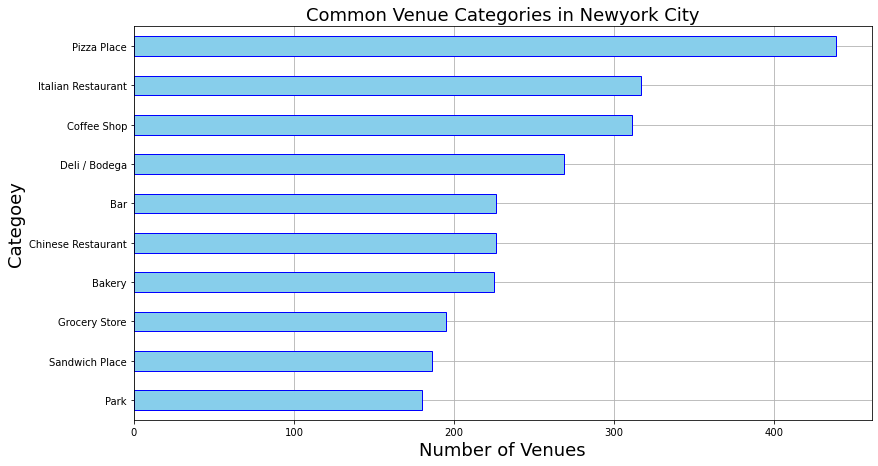

In [61]:
fig, ax = plt.subplots(figsize=(12,6))
newyork_top_vc = newyork_venues['Venue Category'].value_counts(normalize=False)
ax = newyork_top_vc.head(10).plot(kind='barh', grid=True, color = "skyblue", edgecolor='blue');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Common Venue Categories in Newyork City', fontsize=18)
plt.xlabel("Number of Venues", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('newyork_most_common_venue.png', dpi=300)

### Let's see  most Common Venue Categories in Toronto City

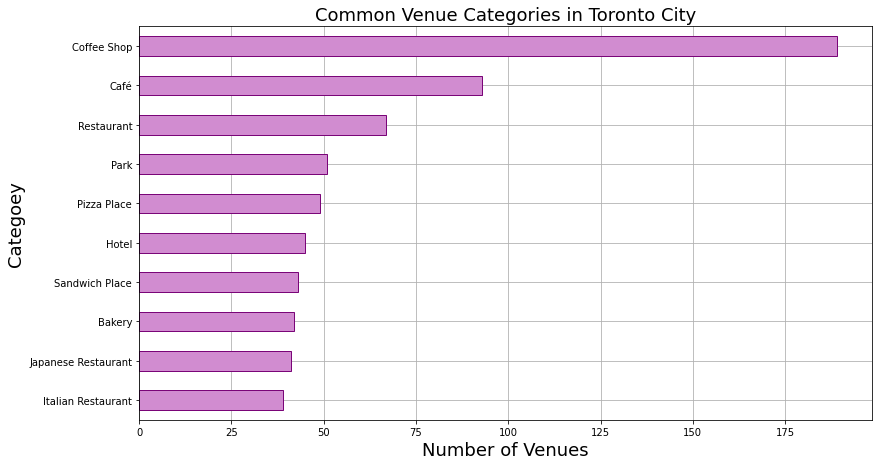

In [62]:
fig, ax = plt.subplots(figsize=(12,6))
toronto_top_vc = toronto_venues['Venue Category'].value_counts(normalize=False)
ax = toronto_top_vc.head(10).plot(kind='barh', grid=True, color = "#d18cd0", edgecolor='#7a0578');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Common Venue Categories in Toronto City', fontsize=18)
plt.xlabel("Number of Venues", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('toronto_most_common_venue.png', dpi=300)

### Let's see the Venue Categories that exist in more Neighborhoods Newyork City

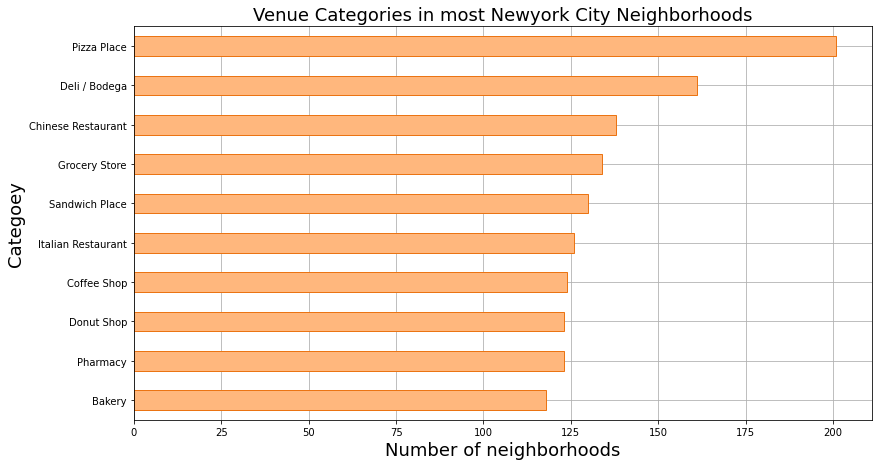

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
newyork_groupby = newyork_onehot.groupby('Neighborhood_').max().reset_index()
newyork_sorted = newyork_groupby.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
ax = newyork_sorted.head(10).plot(kind='barh', grid=True, color = "#ffb77d", edgecolor='#eb7413');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Venue Categories in most Newyork City Neighborhoods', fontsize=18)
plt.xlabel("Number of neighborhoods", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('newyork_venue_in_more_neighborhood.png', dpi=300)

### Let's see the Venue Categories that exist in more Neighborhoods Toronto City

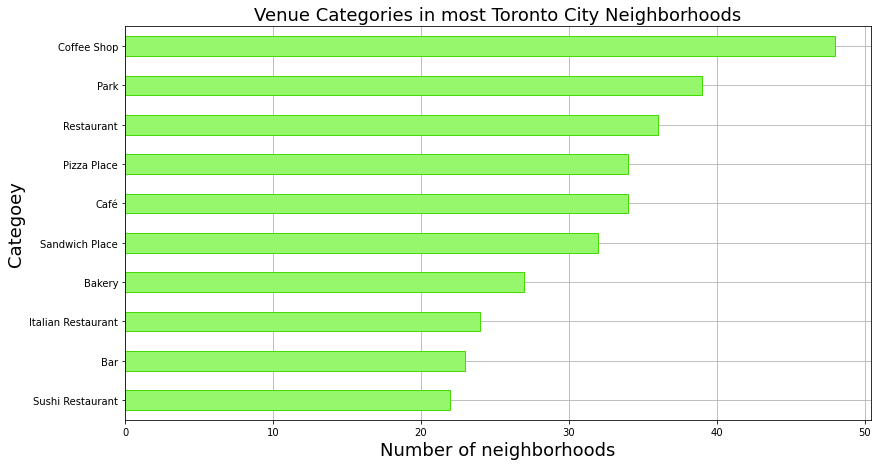

In [64]:
fig, ax = plt.subplots(figsize=(12,6))
toronto_groupby = toronto_onehot.groupby('Neighborhood_').max().reset_index()
toronto_sorted = toronto_groupby.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
ax = toronto_sorted.head(10).plot(kind='barh', grid=True, color = "#96f76d", edgecolor='#44db04');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Venue Categories in most Toronto City Neighborhoods', fontsize=18)
plt.xlabel("Number of neighborhoods", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('toronto_venue_in_more_neighborhood.png', dpi=300)

### Now let's find the Rare Categories in Newyork City

In [65]:
newyork_bottom_venue_count = newyork_venues['Venue Category'].value_counts(normalize=False)
newyork_bottom_venue_count = newyork_bottom_venue_count.tail(10).to_frame('Count')
newyork_bottom_venue_count.index.names = ['Venue Category']
newyork_bottom_venue_count

,Count
Venue Category,
College Bookstore,1
Pakistani Restaurant,1
Beach Bar,1
Stadium,1
Herbs & Spices Store,1
Professional & Other Places,1
College Stadium,1
Nightlife Spot,1
Insurance Office,1


### Now let's find the Rare Categories in Toronto City

In [66]:
toronto_bottom_venue_count = toronto_venues['Venue Category'].value_counts(normalize=False)
toronto_bottom_venue_count = toronto_bottom_venue_count.tail(10).to_frame('Count')
toronto_bottom_venue_count.index.names = ['Venue Category']
toronto_bottom_venue_count

,Count
Venue Category,
Stadium,1
Candy Store,1
Church,1
Hardware Store,1
Cajun / Creole Restaurant,1
Opera House,1
Swim School,1
Social Club,1
Historic Site,1


In [67]:
columns_newyork_only = set(newyork_grouped.columns).difference(set(toronto_grouped.columns))
columns_toronto_only = set(toronto_grouped.columns).difference(set(newyork_grouped.columns))

In [68]:
newyork_grouped_ = newyork_grouped.copy()
newyork_grouped_['Neighborhood_'] = newyork_grouped_['Neighborhood_'].apply(lambda x: x + '_NYC')
toronto_grouped_ = toronto_grouped.copy()
toronto_grouped_['Neighborhood_'] = toronto_grouped_['Neighborhood_'].apply(lambda x: x + '_Toronto')

for c in columns_toronto_only:
    newyork_grouped_[c] = 0
for c in columns_newyork_only:
    toronto_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood_'] + sorted(list(newyork_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
newyork_grouped_ = newyork_grouped_[all_clmns_sorted]
toronto_grouped_ = toronto_grouped_[all_clmns_sorted]
    
newyork_toronto_grouped = pd.concat([newyork_grouped_, toronto_grouped_]).reset_index(drop=True)

In [69]:
newyork_toronto_grouped.loc[303:308,]

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,BBQ Joint,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,IT Services,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant

In [70]:
newyork_toronto_grouped.shape

(402, 460)

In [71]:
# obtaining the most popular categories for each neighborhood
newyork_toronto_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
newyork_toronto_neighborhoods_categories_sorted['Neighborhood_'] = newyork_toronto_grouped['Neighborhood_']

for ind in np.arange(newyork_toronto_grouped.shape[0]):
    newyork_toronto_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        newyork_toronto_grouped.iloc[ind, :], num_top_venues)

newyork_toronto_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Allerton_NYC,Pizza Place,Chinese Restaurant,Spa,Deli / Bodega,Supermarket,Discount Store,Breakfast Spot,Fried Chicken Joint,Martial Arts School,Electronics Store
1,Annadale_NYC,Pizza Place,American Restaurant,Diner,Train Station,Food,Park,Dance Studio,Deli / Bodega,Restaurant,Event Space
2,Arden Heights_NYC,Deli / Bodega,Pharmacy,Bus Stop,Coffee Shop,Pizza Place,Ethiopian Restaurant,Event Service,Escape Room,Farm,Event Space
3,Arlington_NYC,Deli / Bodega,Boat or Ferry,Bus Stop,Coffee Shop,Grocery Store,Home Service,Event Service,Ethiopian Restaurant,Farm,Event Space
4,Arrochar_NYC,Bus Stop,Deli / Bodega,Italian Restaurant,Athletics & Sports,Supermarket,Bagel Shop,Pizza Place,Pharmacy,Liquor Store,Outdoors & Recreation


## Clustering combined neighborhoods of Newyork and Toronto cities

In [72]:
# the number of clusters
kclusters = 5
newyork_toronto_grouped_clustering = newyork_toronto_grouped.drop('Neighborhood_', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 2, 0, 2, 0], dtype=int32)

In [73]:
# add clustering labels
newyork_toronto_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_toronto_merged = newyork_toronto_neighborhoods_categories_sorted.set_index('Neighborhood_')
newyork_toronto_merged.iloc[300:310] # check the last columns!

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Wingate_NYC,0,Fried Chicken Joint,Bakery,Health & Beauty Service,Pharmacy,Donut Shop,Other Great Outdoors,Gym / Fitness Center,Liquor Store,Farmers Market,Discount Store
Woodhaven_NYC,0,Deli / Bodega,Bank,Pharmacy,Park,Donut Shop,Latin American Restaurant,Mexican Restaurant,Sandwich Place,Restaurant,Bagel Shop
Woodlawn_NYC,0,Pub,Deli / Bodega,Pizza Place,Bar,Playground,Cosmetics Shop,Rental Car Location,Plaza,Donut Shop,Train Station
Woodrow_NYC,0,Pharmacy,Grocery Store,Bakery,Donut Shop,Sushi Restaurant,Martial Arts School,Miscellaneous Shop,Coffee Shop,Gift Shop,Bagel Shop
Woodside_NYC,0,Grocery Store,Latin American Restaurant,Filipino Restaurant,Thai Restaurant,Bakery,Pizza Place,Pub,Donut Shop,American Restaurant,Bar
Yorkville_NYC,2,Italian Restaurant,Gym,Bar,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Wine Shop,Japanese Restaurant,Diner,Deli / Bodega
Agincourt_Toronto,2,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Czech Restaurant,Fast Food Restaurant,Escape Room,Ethiopian Restaurant,Event Service
"Alderwood, Long Branch_Toronto",0,Pizza Place,Sandwich Place,Gym,Pharmacy,Coffee Shop,Pub,Fish & Chips Shop,Event Service,Egyptian Restaurant,Food
"Bathurst Manor, Wilson Heights, Downsview North_Toronto",0,Bank,Coffee Shop,Diner,Shopping Mall,Chinese Restaurant,Sandwich Place,Gas Station,Middle Eastern Restaurant,Sushi Restaurant,Pharmacy


### Let's examine the neighborhoods in each of the five clusters:

### Cluster 1

In [74]:
Cluster_1 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 0, :]
Cluster_1

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Allerton_NYC,0,Pizza Place,Chinese Restaurant,Spa,Deli / Bodega,Supermarket,Discount Store,Breakfast Spot,Fried Chicken Joint,Martial Arts School,Electronics Store
Annadale_NYC,0,Pizza Place,American Restaurant,Diner,Train Station,Food,Park,Dance Studio,Deli / Bodega,Restaurant,Event Space
Arden Heights_NYC,0,Deli / Bodega,Pharmacy,Bus Stop,Coffee Shop,Pizza Place,Ethiopian Restaurant,Event Service,Escape Room,Farm,Event Space
Arlington_NYC,0,Deli / Bodega,Boat or Ferry,Bus Stop,Coffee Shop,Grocery Store,Home Service,Event Service,Ethiopian Restaurant,Farm,Event Space
Arrochar_NYC,0,Bus Stop,Deli / Bodega,Italian Restaurant,Athletics & Sports,Supermarket,Bagel Shop,Pizza Place,Pharmacy,Liquor Store,Outdoors & Recreation
Arverne_NYC,0,Surf Spot,Sandwich Place,Metro Station,Pizza Place,Café,Coffee Shop,Restaurant,Thai Restaurant,Bus Stop,Board Shop
Astoria Heights_NYC,0,Bakery,Supermarket,Pizza Place,Bus Station,Playground,Plaza,Hostel,Italian Restaurant,Bowling Alley,Burger Joint
Bath Beach_NYC,0,Dessert Shop,Cantonese Restaurant,Pizza Place,Italian Restaurant,Chinese Restaurant,Pharmacy,Gas Station,Bubble Tea Shop,Fast Food Restaurant,Donut Shop
"Bay Terrace, Staten Island_NYC",0,Supermarket,Liquor Store,Donut Shop,Salon / Barbershop,Home Service,Sushi Restaurant,Playground,Shipping Store,Italian Restaurant,Exhibit


### Cluster 2

In [75]:
Cluster_2 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 1, :]
Cluster_2

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Clason Point_NYC,1,Park,Pool,South American Restaurant,Bus Stop,Scenic Lookout,Boat or Ferry,Grocery Store,Convenience Store,Entertainment Service,Escape Room
Somerville_NYC,1,Park,Yoga Studio,Egyptian Restaurant,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
Todt Hill_NYC,1,Park,Yoga Studio,Egyptian Restaurant,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
Caledonia-Fairbanks_Toronto,1,Park,Women's Store,Pool,Yoga Studio,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
"East Toronto, Broadview North (Old East York)_Toronto",1,Intersection,Park,Convenience Store,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space
Lawrence Park_Toronto,1,Park,Swim School,Bus Line,Yoga Studio,Farm,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
"Milliken, Agincourt North, Steeles East, L'Amoreaux East_Toronto",1,Bakery,Park,Playground,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space
"North Park, Maple Leaf Park, Upwood Park_Toronto",1,Bakery,Park,Construction & Landscaping,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space
Parkwoods_Toronto,1,Park,Food & Drink Shop,Yoga Studio,Farm,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space


### Cluster 3

In [76]:
Cluster_3 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 2, :]
Cluster_3

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Astoria_NYC,2,Middle Eastern Restaurant,Bar,Seafood Restaurant,Greek Restaurant,Hookah Bar,Café,Bakery,Mediterranean Restaurant,Indian Restaurant,Pizza Place
Auburndale_NYC,2,Italian Restaurant,Noodle House,Sushi Restaurant,Toy / Game Store,Pet Store,Pharmacy,Train,Athletics & Sports,Korean Restaurant,Supermarket
Battery Park City_NYC,2,Park,Hotel,Gym,Coffee Shop,Memorial Site,Gourmet Shop,Boat or Ferry,Food Court,Burger Joint,Clothing Store
Bay Ridge_NYC,2,Italian Restaurant,Spa,Pizza Place,Bar,Greek Restaurant,American Restaurant,Hookah Bar,Mexican Restaurant,Thai Restaurant,Café
"Bay Terrace, Queens_NYC",2,Clothing Store,Shoe Store,Mobile Phone Shop,Kids Store,Cosmetics Shop,Women's Store,Donut Shop,American Restaurant,Men's Store,Supermarket
Bayside_NYC,2,Bar,Pizza Place,Sushi Restaurant,Chinese Restaurant,American Restaurant,Indian Restaurant,Burger Joint,Italian Restaurant,Steakhouse,Spa
Bedford Stuyvesant_NYC,2,Coffee Shop,Café,Bar,Pizza Place,Boutique,BBQ Joint,Gourmet Shop,Cocktail Bar,Thrift / Vintage Store,Park
Boerum Hill_NYC,2,Dance Studio,Coffee Shop,Bar,Spa,Arts & Crafts Store,Sandwich Place,French Restaurant,Furniture / Home Store,Bakery,Cosmetics Shop
Brooklyn Heights_NYC,2,Deli / Bodega,Yoga Studio,Park,Italian Restaurant,Cosmetics Shop,Gym,Plaza,Pizza Place,Diner,Coffee Shop


### Cluster 4

In [77]:
Cluster_4 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 3, :]
Cluster_4

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Butler Manor_NYC,3,Baseball Field,Pool,Yoga Studio,Fast Food Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
"Humberlea, Emery_Toronto",3,Baseball Field,Yoga Studio,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East_Toronto",3,Construction & Landscaping,Baseball Field,Yoga Studio,Fast Food Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit


### Cluster 5

In [78]:
Cluster_5 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 4, :]
Cluster_5

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Graniteville_NYC,4,Boat or Ferry,Grocery Store,Yoga Studio,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space
Howland Hook_NYC,4,Boat or Ferry,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit


In [79]:
clust_cats = []
clusters = [Cluster_1, Cluster_2, Cluster_3, Cluster_4, Cluster_5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(newyork_venues[newyork_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(toronto_venues[toronto_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100

In [80]:
! pip install tabulate
from tabulate import tabulate
for i in range(kclusters):
    df = pd.DataFrame(data=clust_cats[i], columns=["% of venues"])
#     print(type(clust_cats[i]))
#     df = pd.DataFrame(data=clust_cats[i])
#     print(df.head(7))
    print("\n\n\t Cluster {}".format(i+1))
    print(tabulate(df.head(7), headers = 'keys', tablefmt = 'fancy_grid'))




	 Cluster 1
╒════════════════════╤═══════════════╕
│                    │   % of venues │
╞════════════════════╪═══════════════╡
│ Pizza Place        │       6.29871 │
├────────────────────┼───────────────┤
│ Deli / Bodega      │       4.06573 │
├────────────────────┼───────────────┤
│ Chinese Restaurant │       3.20202 │
├────────────────────┼───────────────┤
│ Pharmacy           │       3.09669 │
├────────────────────┼───────────────┤
│ Donut Shop         │       2.9703  │
├────────────────────┼───────────────┤
│ Bank               │       2.82284 │
├────────────────────┼───────────────┤
│ Grocery Store      │       2.82284 │
╘════════════════════╧═══════════════╛


	 Cluster 2
╒═══════════════════╤═══════════════╕
│                   │   % of venues │
╞═══════════════════╪═══════════════╡
│ Park              │      46.1538  │
├───────────────────┼───────────────┤
│ Convenience Store │       7.69231 │
├───────────────────┼───────────────┤
│ Playground        │       5.12821 │
├────

In [83]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

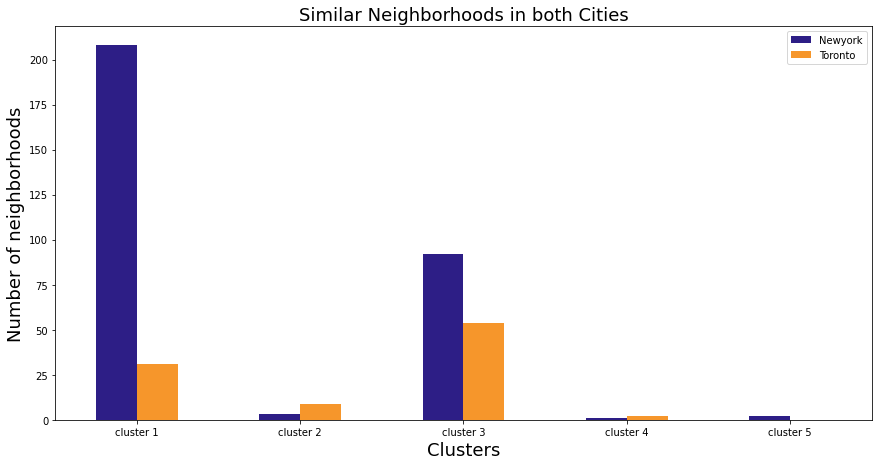

In [82]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'Newyork': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=(12,6))
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)

# plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
plt.tight_layout()
plt.title('Similar Neighborhoods in both Cities', fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.ylabel("Number of neighborhoods", fontsize=18)
fig.savefig('similar_neighborhoods.png', dpi=300)